In [ ]:
import torch
from torch import nn, tensor
import torch.nn.functional as F
from datasets import load_dataset
import fastcore.all as fc
import torchvision.transforms.functional as TF
from functools import partial
from torcheval.metrics import MulticlassAccuracy
from torch import optim

from minai.datasets import inplace
from minai.learner import DataLoaders, MetricsCB, DeviceCB, ProgressCB, TrainLearner, MomentumLearner, LRFinderCB
from minai.init import get_model, GeneralRelu,init_weights
from minai.activations import ActivationStats, set_seed

set_seed(42)

# Data

In [ ]:
bs=1024
x1, y1 = 'image', 'label'
ds = load_dataset('fashion_mnist')

In [ ]:
ds['train'][x1][0]

In [ ]:
x_mean, x_std = tensor(0.28), tensor(0.35)

@inplace
def transformi(b): b[x1] = [(TF.to_tensor(o) - x_mean)/x_std for o in b[x1]]

In [ ]:
dsd = ds.with_transform(transformi)

In [ ]:
dls = DataLoaders.from_dd(dsd, batch_size=bs)
dt = dls.train
xb, yb = next(iter(dt))
xb.shape, yb.shape

(torch.Size([1024, 1, 28, 28]), torch.Size([1024]))

In [ ]:
xb.mean(), xb.std()

(tensor(0.01), tensor(1.01))

# SGD

In [ ]:
class SGD:
    def __init__(self, params, lr, wd=1e-6):
        params = list(params)
        fc.store_attr()
        self.i = 0
    
    def step(self):
        with torch.no_grad():
            for p in self.params:
                self.reg_step(p)
                self.opt_step(p)
        self.i += 1

    def opt_step(self, p): p -= p.grad * self.lr
    
    def reg_step(self, p):
        if self.wd != 0: p *= 1 - self.lr * self.wd 
    
    def zero_grad(self):
        for p in self.params: p.grad.data.zero_() #p.zero_grad()

In [ ]:
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights,leaky=0.1)
metrics = MetricsCB(accuracy=MulticlassAccuracy())

lrf_cbs = [DeviceCB(), ProgressCB(plot=True), LRFinderCB()]
cbs = [DeviceCB(), ProgressCB(plot=True), metrics]

In [ ]:
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=1e-2, cbs=lrf_cbs)
learn.fit(1)

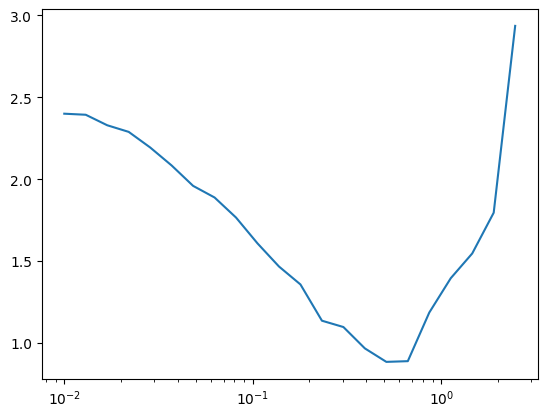

In [ ]:
lrf_cbs[-1].plot()

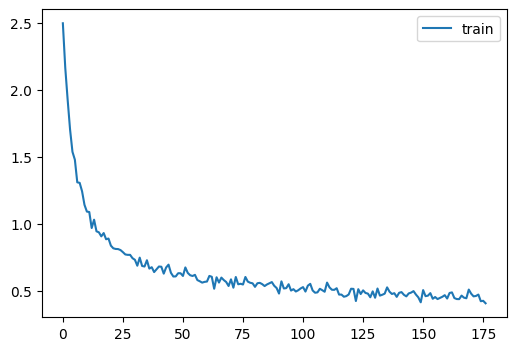

In [ ]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=0.1, cbs=cbs, opt_func=SGD)
learn.fit(3)

## Momentum

In [ ]:
class Momentum(SGD):
    def __init__(self, params, lr, wd = 0., mom=0.9):
        super().__init__(params, lr, wd)
        self.mom = mom
    
    def opt_step(self, p):
        if self.i==0: p.avg_grad = torch.zeros_like(p.grad)
        p.avg_grad = self.mom * p.avg_grad + (1 - self.mom) * p.grad
        p -= self.lr * p.avg_grad

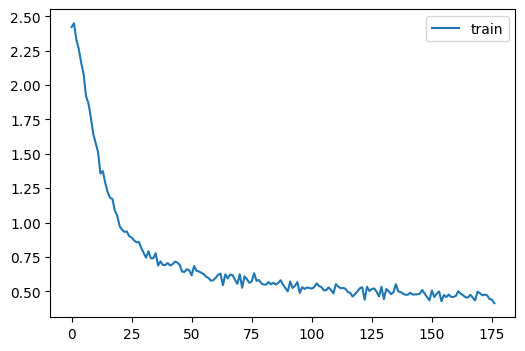

In [ ]:
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=0.1, cbs=cbs, opt_func=Momentum)
learn.fit(3)

## RMSProp

In [ ]:
class RMSProp(SGD):
    def __init__(self, params, lr, wd=0., sqr_mom=0.99, eps=1e-6):
        super().__init__(params, lr, wd)
        self.sqr_mom = sqr_mom
        self.eps = eps
    
    def opt_step(self, p):
        if self.i == 0: p.grad_sqr = p.grad ** 2
        p.grad_sqr = self.sqr_mom * p.grad_sqr + (1 - self.sqr_mom) * (p.grad ** 2)
        upd = p.grad / (p.grad_sqr.sqrt() + self.eps)
        p -= self.lr * upd

In [ ]:
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=1e-4, cbs=lrf_cbs, opt_func=optim.RMSprop)
learn.fit(1)

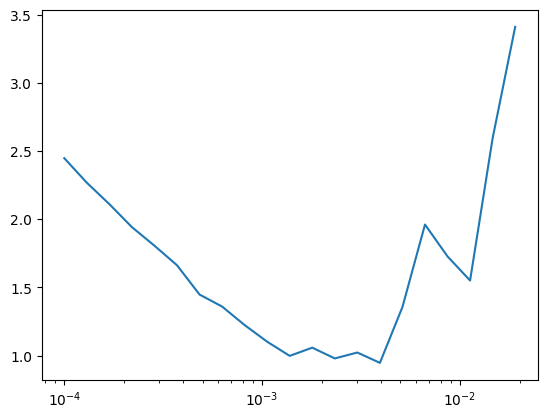

In [ ]:
lrf_cbs[-1].plot()

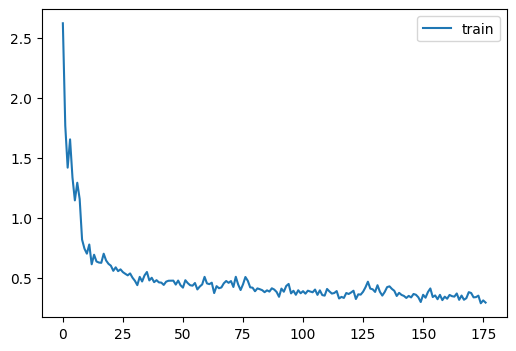

In [ ]:
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=6e-3, cbs=cbs, opt_func=RMSProp)
learn.fit(3)

## Adam
> RMSProp + Momentum

In [ ]:
class Adam(SGD):
    def __init__(self, params, lr, wd=0., beta1=0.9, beta2=0.99, eps=1e-6):
        super().__init__(params, lr, wd)
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
    
    def opt_step(self, p):
        if self.i == 0: 
            p.sqr_grad = torch.zeros_like(p.grad)
            p.avg_grad = torch.zeros_like(p.grad)
        
        p.sqr_grad = p.sqr_grad * self.beta2 + (1 - self.beta2) * p.grad** 2
        unbiased_sqr_grad = p.sqr_grad / (1 - self.beta2**(self.i + 1))
        
        p.avg_grad = p.avg_grad * self.beta1 + (1 - self.beta1) * p.grad
        unbiased_avg_grad = p.avg_grad / (1 - self.beta1**(self.i + 1))
        
        p -= self.lr * (unbiased_avg_grad/(unbiased_sqr_grad + self.eps).sqrt())

In [ ]:
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=1e-4, cbs=lrf_cbs, opt_func=optim.Adam)
learn.fit(1)

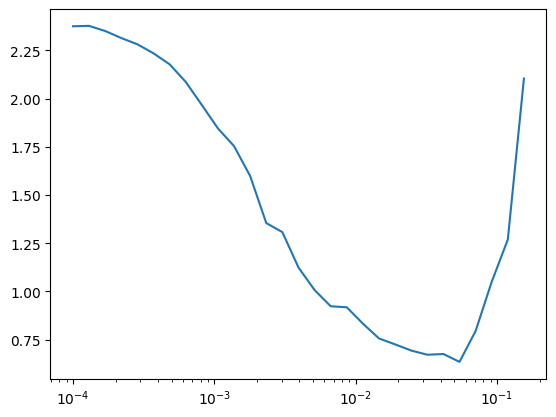

In [ ]:
lrf_cbs[-1].plot()

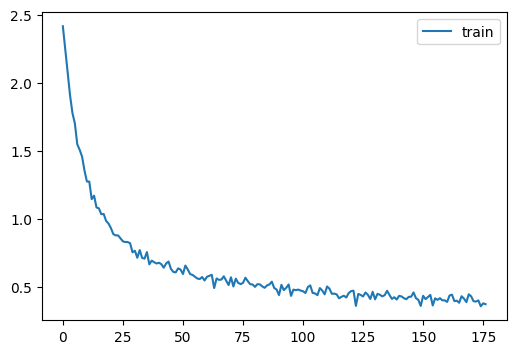

In [ ]:
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=1e-3, cbs=cbs, opt_func=Adam)
learn.fit(3)

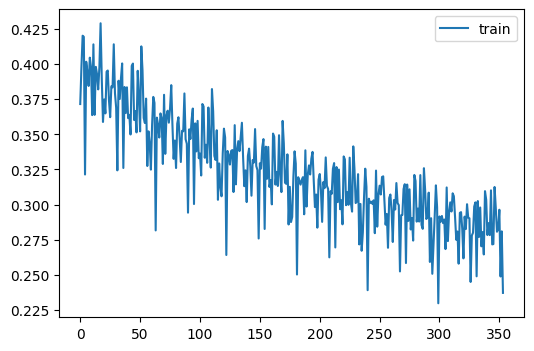

In [ ]:
learn = TrainLearner(model, dls, F.cross_entropy, lr=1e-3, cbs=cbs, opt_func=Adam)
learn.fit(6)